In [1]:
import sys
import os

import ipdb as pdb
import json
import random
import shutil
from termcolor import colored
import time

import torch
torch.backends.cudnn.enabled = True
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import h5py

import vr.utils as utils
import vr.preprocess
from vr.data import ClevrDataset, ClevrDataLoader
from vr.models.module_net import ModuleNet
from vr.models.seq2seq import Seq2Seq
from vr.models.baselines import LstmModel, CnnLstmModel, CnnLstmSaModel
from vr.models.filmed_net import FiLMedNet
from vr.models.film_gen import FiLMGen

In [2]:
def parse_int_list(s):
    if s == '': return ()
    return tuple(int(n) for n in s.split(','))

In [3]:
def get_state(m):
    if m is None:
        return None
    state = {}
    for k, v in m.state_dict().items():
        state[k] = v.clone()
    return state

In [4]:
def get_program_generator():
    vocab = utils.load_vocab(vocab_json)
    if program_generator_start_from is not None:
        pg, kwargs = utils.load_program_generator(
            program_generator_start_from, model_type=model_type)
        cur_vocab_size = pg.encoder_embed.weight.size(0)
        if cur_vocab_size != len(vocab['question_token_to_idx']):
            print('Expanding vocabulary of program generator')
            pg.expand_encoder_vocab(vocab['question_token_to_idx'])
            kwargs['encoder_vocab_size'] = len(vocab['question_token_to_idx'])
    else:
        kwargs = {
            'encoder_vocab_size': len(vocab['question_token_to_idx']),
            'decoder_vocab_size': len(vocab['program_token_to_idx']),
            'wordvec_dim': rnn_wordvec_dim,
            'hidden_dim': rnn_hidden_dim,
            'rnn_num_layers': rnn_num_layers,
            'rnn_dropout': rnn_dropout,
        }
        if model_type == 'FiLM':
            kwargs['parameter_efficient'] = program_generator_parameter_efficient == 1
            kwargs['output_batchnorm'] = rnn_output_batchnorm == 1
            kwargs['bidirectional'] = bidirectional == 1
            kwargs['encoder_type'] = encoder_type
            kwargs['decoder_type'] = decoder_type
            kwargs['gamma_option'] = gamma_option
            kwargs['gamma_baseline'] = gamma_baseline
            kwargs['num_modules'] = num_modules
            kwargs['module_num_layers'] = module_num_layers
            kwargs['module_dim'] = module_dim
            kwargs['debug_every'] = debug_every
            pg = FiLMGen(**kwargs)
        else:
            pg = Seq2Seq(**kwargs)
    pg.cuda()
    pg.train()
    return pg, kwargs

In [5]:
def get_execution_engine():
    vocab = utils.load_vocab(vocab_json)
    if execution_engine_start_from is not None:
        ee, kwargs = utils.load_execution_engine(
            execution_engine_start_from, model_type=model_type)
    else:
        kwargs = {
            'vocab': vocab,
            'feature_dim': parse_int_list(feature_dim),
            'stem_batchnorm': module_stem_batchnorm == 1,
            'stem_num_layers': module_stem_num_layers,
            'module_dim': module_dim,
            'module_residual': module_residual == 1,
            'module_batchnorm': module_batchnorm == 1,
            'classifier_proj_dim': classifier_proj_dim,
            'classifier_downsample': classifier_downsample,
            'classifier_fc_layers': parse_int_list(classifier_fc_dims),
            'classifier_batchnorm': classifier_batchnorm == 1,
            'classifier_dropout': classifier_dropout,
        }
        if model_type == 'FiLM':
            kwargs['num_modules'] = num_modules
            kwargs['stem_kernel_size'] = module_stem_kernel_size
            kwargs['stem_stride'] = module_stem_stride
            kwargs['stem_padding'] = module_stem_padding
            kwargs['module_num_layers'] = module_num_layers
            kwargs['module_batchnorm_affine'] = module_batchnorm_affine == 1
            kwargs['module_dropout'] = module_dropout
            kwargs['module_input_proj'] = module_input_proj
            kwargs['module_kernel_size'] = module_kernel_size
            kwargs['use_gamma'] = use_gamma == 1
            kwargs['use_beta'] = use_beta == 1
            kwargs['use_coords'] = use_coords
            kwargs['debug_every'] = debug_every
            kwargs['print_verbose_every'] = print_verbose_every
            kwargs['condition_method'] = condition_method
            kwargs['condition_pattern'] = parse_int_list(condition_pattern)
            ee = FiLMedNet(**kwargs)
        else:
            ee = ModuleNet(**kwargs)
    ee.cuda()
    ee.train()
    return ee, kwargs

In [6]:
def set_mode(mode, models):
    assert mode in ['train', 'eval']
    for m in models:
        if m is None: continue
        if mode == 'train': m.train()
        if mode == 'eval': m.eval()

In [7]:
def check_accuracy(program_generator, execution_engine, baseline_model, loader):
    set_mode('eval', [program_generator, execution_engine, baseline_model])
    num_correct, num_samples = 0, 0
    for batch in loader:
        questions, _, feats, answers, programs, _ = batch
        if isinstance(questions, list):
            questions = questions[0]

        questions_var = Variable(questions.cuda())
        feats_var = Variable(feats.cuda())
        answers_var = Variable(feats.cuda())
        if programs[0] is not None:
            programs_var = Variable(programs.cuda())

        scores = None  # Use this for everything but PG
        if model_type == 'PG':
            vocab = utils.load_vocab(vocab_json)
            for i in range(questions.size(0)):
                program_pred = program_generator.sample(Variable(questions[i:i+1].cuda(), volatile=True))
                program_pred_str = vr.preprocess.decode(program_pred, vocab['program_idx_to_token'])
                program_str = vr.preprocess.decode(programs[i], vocab['program_idx_to_token'])
                if program_pred_str == program_str:
                    num_correct += 1
                num_samples += 1
        elif model_type == 'EE':
            scores = execution_engine(feats_var, programs_var)
        elif model_type == 'PG+EE':
            programs_pred = program_generator.reinforce_sample(
                questions_var, argmax=True)
            scores = execution_engine(feats_var, programs_pred)
        elif model_type == 'FiLM':
            programs_pred = program_generator(questions_var)
            scores = execution_engine(feats_var, programs_pred)
        elif model_type in ['LSTM', 'CNN+LSTM', 'CNN+LSTM+SA']:
            scores = baseline_model(questions_var, feats_var)

        if scores is not None:
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == answers).sum()
            num_samples += preds.size(0)

        if num_val_samples is not None and num_samples >= num_val_samples:
            break

    set_mode('train', [program_generator, execution_engine, baseline_model])
    acc = float(num_correct) / num_samples
    return acc

In [8]:
def check_grad_num_nans(model, model_name='model'):
    grads = [p.grad for p in model.parameters() if p.grad is not None]
    num_nans = [np.sum(np.isnan(grad.data.cpu().numpy())) for grad in grads]
    nan_checks = [num_nan == 0 for num_nan in num_nans]
    if False in nan_checks:
        print('Nans in ' + model_name + ' gradient!')
        print(num_nans)
        pdb.set_trace()
        raise(Exception)

In [9]:
def train_loop(train_loader, val_loader):
    vocab = utils.load_vocab(vocab_json)
    program_generator, pg_kwargs, pg_optimizer = None, None, None
    execution_engine, ee_kwargs, ee_optimizer = None, None, None
    baseline_model, baseline_kwargs, baseline_optimizer = None, None, None
    baseline_type = None

    pg_best_state, ee_best_state, baseline_best_state = None, None, None
    
    optim_method = getattr(torch.optim, optimizer)
    
    if model_type in ['FiLM', 'PG', 'PG+EE']:
        program_generator, pg_kwargs = get_program_generator()
        pg_optimizer = optim_method(program_generator.parameters(),
                                    lr=learning_rate,
                                    weight_decay=weight_decay)
        print('Here is the conditioning network:')
        print(program_generator)
    
    if model_type in ['FiLM', 'EE', 'PG+EE']:
        execution_engine, ee_kwargs = get_execution_engine()
        ee_optimizer = optim_method(execution_engine.parameters(),
                                    lr=learning_rate,
                                    weight_decay=weight_decay)
        print('Here is the conditioned network:')
        print(execution_engine)
    
    loss_fn = torch.nn.CrossEntropyLoss().cuda()
    stats = {
        'train_losses': [],
        'train_rewards': [],
        'train_losses_ts': [],
        'train_accs': [],
        'val_accs': [],
        'val_accs_ts': [],
        'best_val_acc': -1,
        'model_t': 0,
    }
    
    t, epoch, reward_moving_average = 0, 0, 0
    
    set_mode('train', [program_generator, execution_engine, baseline_model])
    
    print('train_loader has %d samples' % len(train_loader.dataset))
    print('val_loader has %d samples' % len(val_loader.dataset))

    num_checkpoints = 0
    epoch_start_time = 0.0
    epoch_total_time = 0.0
    train_pass_total_time = 0.0
    val_pass_total_time = 0.0
    running_loss = 0.0
    
    while t < num_iterations:
        if (epoch > 0) and (use_time == 1):
            epoch_time = time.time() - epoch_start_time
            epoch_total_time += epoch_time
            print(colored('EPOCH PASS AVG TIME: ' + str(epoch_total_time / epoch), 'white'))
            print(colored('Epoch Pass Time      : ' + str(epoch_time), 'white'))
        epoch_start_time = time.time()

        epoch += 1
        print('Starting epoch %d' % epoch)
        for batch in train_loader:
            t += 1
            questions, _, feats, answers, programs, _ = batch
            if isinstance(questions, list):
                questions = questions[0]
            questions_var = Variable(questions.cuda())
            feats_var = Variable(feats.cuda())
            answers_var = Variable(answers.cuda())
            if programs[0] is not None:
                programs_var = Variable(programs.cuda())
            reward = None

            if model_type == 'FiLM':
                if set_execution_engine_eval == 1:
                    set_mode('eval', [execution_engine])
                programs_pred = program_generator(questions_var)
                scores = execution_engine(feats_var, programs_pred)
                loss = loss_fn(scores, answers_var)

                pg_optimizer.zero_grad()
                ee_optimizer.zero_grad()

                if debug_every <= -2:
                    pdb.set_trace()

                loss.backward()

                if debug_every < float('inf'):
                    check_grad_num_nans(execution_engine, 'FiLMedNet')
                    check_grad_num_nans(program_generator, 'FiLMGen')

                if train_program_generator == 1:
                    if grad_clip > 0:
                        torch.nn.utils.clip_grad_norm(program_generator.parameters(), grad_clip)
                    pg_optimizer.step()
                if train_execution_engine == 1:
                    if grad_clip > 0:
                        torch.nn.utils.clip_grad_norm(execution_engine.parameters(), grad_clip)
                    ee_optimizer.step()

            if t % record_loss_every == 0:
                running_loss += loss.item()
                avg_loss = running_loss / record_loss_every
                print(t, avg_loss)
                stats['train_losses'].append(avg_loss)
                stats['train_losses_ts'].append(t)
                if reward is not None:
                    stats['train_rewards'].append(reward)
                running_loss = 0.0
            else:
                running_loss += loss.item()

            if t % checkpoint_every == 0:
                num_checkpoints += 1
                print('Checking training accuracy ... ')
                start = time.time()
                with torch.no_grad():
                    train_acc = check_accuracy(program_generator, execution_engine,
                                               baseline_model, train_loader)
                if use_time == 1:
                    train_pass_time = (time.time() - start)
                    train_pass_total_time += train_pass_time
                    print(colored('TRAIN PASS AVG TIME: ' + str(train_pass_total_time / num_checkpoints), 'red'))
                    print(colored('Train Pass Time      : ' + str(train_pass_time), 'red'))
                print('train accuracy is', train_acc)
                print('Checking validation accuracy ...')
                start = time.time()
                with torch.no_grad():
                    val_acc = check_accuracy(program_generator, execution_engine,
                                             baseline_model, val_loader)
                if use_time == 1:
                    val_pass_time = (time.time() - start)
                    val_pass_total_time += val_pass_time
                    print(colored('VAL PASS AVG TIME:   ' + str(val_pass_total_time / num_checkpoints), 'cyan'))
                    print(colored('Val Pass Time        : ' + str(val_pass_time), 'cyan'))
                print('val accuracy is ', val_acc)
                stats['train_accs'].append(train_acc)
                stats['val_accs'].append(val_acc)
                stats['val_accs_ts'].append(t)

                if val_acc > stats['best_val_acc']:
                    stats['best_val_acc'] = val_acc
                    stats['model_t'] = t
                    best_pg_state = get_state(program_generator)
                    best_ee_state = get_state(execution_engine)
                    best_baseline_state = get_state(baseline_model)

                checkpoint = {
#                     'args': args.__dict__,
                    'program_generator_kwargs': pg_kwargs,
                    'program_generator_state': best_pg_state,
                    'execution_engine_kwargs': ee_kwargs,
                    'execution_engine_state': best_ee_state,
                    'baseline_kwargs': baseline_kwargs,
                    'baseline_state': best_baseline_state,
                    'baseline_type': baseline_type,
                    'vocab': vocab
                }

                for k, v in stats.items():
                    checkpoint[k] = v
                print('Saving checkpoint to %s' % checkpoint_path)
                torch.save(checkpoint, checkpoint_path)
                del checkpoint['program_generator_state']
                del checkpoint['execution_engine_state']
                del checkpoint['baseline_state']
                with open(checkpoint_path + '.json', 'w') as f:
                    json.dump(checkpoint, f)

            if t == num_iterations:
                break
    return stats

**===================================================== Args ===========================================================**

In [10]:
# Input data
train_questions_h5 = 'data/train_questions.h5'
train_features_h5 = 'data/train_features.h5'
val_questions_h5 = 'data/val_questions.h5'
val_features_h5 = 'data/val_features.h5'
feature_dim = '1024,14,14'
vocab_json = 'data/vocab.json'

loader_num_workers = 1
use_local_copies = 0
cleanup_local_copies = 1

family_split_file = None
num_train_samples = None
num_val_samples = 149991
shuffle_train_data = 1

# What type of model to use and which parts to train
model_type = 'FiLM'
#   choices=['FiLM', 'PG', 'EE', 'PG+EE', 'LSTM', 'CNN+LSTM', 'CNN+LSTM+SA']
train_program_generator = 1
train_execution_engine = 1
baseline_train_only_rnn = 0

# Start from an existing checkpoint
program_generator_start_from = None
execution_engine_start_from = None
baseline_start_from = None

# RNN options
rnn_wordvec_dim = 200
rnn_hidden_dim = 4096
rnn_num_layers = 1
rnn_dropout = 0

# Module net / FiLMedNet options
module_stem_num_layers = 1
module_stem_batchnorm = 1
module_dim = 128
module_residual = 1
module_batchnorm = 1

# FiLM only options
set_execution_engine_eval = 0
program_generator_parameter_efficient = 1
rnn_output_batchnorm = 0
bidirectional = 0
encoder_type = 'gru' 
#   choices=['linear', 'gru', 'lstm'])
decoder_type = 'linear' 
#   choices=['linear', 'gru', 'lstm'])
gamma_option = 'linear' 
#   choices=['linear', 'sigmoid', 'tanh', 'exp'])
gamma_baseline = 1
num_modules = 4
module_stem_kernel_size = 3
module_stem_stride = 1
module_stem_padding = None
module_num_layers = 1  # Only mnl=1 currently implemented
module_batchnorm_affine = 0  # 1 overrides other factors
module_dropout = 0e-2
module_input_proj = 1  # Inp conv kernel size (0 for None)
module_kernel_size = 3
condition_method = 'bn-film' 
#   choices=['block-input-film', 'block-output-film', 'bn-film', 'concat', 'conv-film', 'relu-film'])
condition_pattern = '1,1,1,1'  # List of 0/1's (len = # FiLMs)
use_gamma = 1
use_beta = 1
use_coords = 1  # 0: none, 1: low usage, 2: high usage
grad_clip = 0  # <= 0 for no grad clipping
debug_every = float('inf') # inf for no pdb
print_verbose_every = 200000  # inf for min print

# # CNN options (for baselines)
# cnn_res_block_dim = 128
# cnn_num_res_blocks = 0
# cnn_proj_dim = 512
# cnn_pooling = 'maxpool2',
# #   choices=['none', 'maxpool2'])

# # Stacked-Attention options
# stacked_attn_dim = 512
# num_stacked_attn = 2

# Classifier options
classifier_proj_dim = 512
classifier_downsample = 'maxpoolfull' 
#   choices=['maxpool2', 'maxpool3', 'maxpool4', 'maxpool5', 'maxpool7', 'maxpoolfull', 'none',
#            'avgpool2', 'avgpool3', 'avgpool4', 'avgpool5', 'avgpool7', 'avgpoolfull', 'aggressive'])
classifier_fc_dims = '1024'
classifier_batchnorm = 1
classifier_dropout = 0

# Optimization options
batch_size = 64
num_iterations = 200000
optimizer = 'Adam'
#   choices=['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'ASGD', 'RMSprop', 'SGD'])
learning_rate = 3e-4
reward_decay = 0.9
weight_decay = 1e-5
                    
# Output options
checkpoint_path = "data/model/film.pt"
randomize_checkpoint_path = 0
avoid_checkpoint_override = 0
record_loss_every = 100
checkpoint_every = 10000
use_time = 0

**===================================================== Main ===========================================================**

In [11]:
if randomize_checkpoint_path == 1:
    name, ext = os.path.splitext(checkpoint_path)
    num = random.randint(1, 1000000)
    checkpoint_path = '%s_%06d%s' % (name, num, ext)
print('Will save checkpoints to %s' % checkpoint_path)

Will save checkpoints to data/model/film.pt


In [12]:
if use_local_copies == 1:
    shutil.copy(train_question_h5, '/tmp/train_questions.h5')
    shutil.copy(train_features_h5, '/tmp/train_features.h5')
    shutil.copy(val_question_h5, '/tmp/val_questions.h5')
    shutil.copy(val_features_h5, '/tmp/val_features.h5')
    train_question_h5 = '/tmp/train_questions.h5'
    train_features_h5 = '/tmp/train_features.h5'
    val_question_h5 = '/tmp/val_questions.h5'
    val_features_h5 = '/tmp/val_features.h5'

In [13]:
question_families = None
if family_split_file is not None:
    with open(family_split_file, 'r') as f:
        question_families = json.load(f)

In [14]:
vocab = utils.load_vocab(vocab_json)

train_loader_kwargs = {
    'question_h5': train_questions_h5,
    'feature_h5': train_features_h5,
    'vocab': vocab,
    'batch_size': batch_size,
    'shuffle': shuffle_train_data == 1,
#     'question_families': question_families,
#     'max_samples': num_train_samples,
#     'num_workers': loader_num_workers,
}

val_loader_kwargs = {
    'question_h5': val_questions_h5,
    'feature_h5': val_features_h5,
    'vocab': vocab,
    'batch_size': batch_size,
#     'question_families': question_families,
#     'max_samples': num_val_samples,
#     'num_workers': loader_num_workers,
}

In [15]:
train_loader = ClevrDataLoader(**train_loader_kwargs)
val_loader = ClevrDataLoader(**val_loader_kwargs)

Reading features from data/train_features.h5
Reading questions from  data/train_questions.h5
Reading question data into memory
Reading features from data/val_features.h5
Reading questions from  data/val_questions.h5
Reading question data into memory


In [16]:
stats = train_loop(train_loader, val_loader)

Here is the conditioning network:
FiLMGen(
  (encoder_embed): Embedding(93, 200)
  (encoder_rnn): GRU(200, 4096, batch_first=True)
  (decoder_linear): Linear(in_features=4096, out_features=1024, bias=True)
)
Here is the conditioned network:
FiLMedNet(
  (stem): Sequential(
    (0): Conv2d(1026, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (0): FiLMedResBlock(
    (input_proj): Conv2d(130, 128, kernel_size=(1, 1), stride=(1, 1))
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (film): FiLM()
  )
  (1): FiLMedResBlock(
    (input_proj): Conv2d(130, 128, kernel_size=(1, 1), stride=(1, 1))
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Fa

22800 0.552116745710373
22900 0.5573549512028694
23000 0.5488115471601486
23100 0.5519526559114456
23200 0.5430575439333916
23300 0.5500772643089294
23400 0.5449420735239983
23500 0.5522625967860222
23600 0.5493263205885888
23700 0.5344525122642517
23800 0.5533543500304222
23900 0.5450868389010429
24000 0.5296371081471443
24100 0.5251435461640358
24200 0.5309477335214615
24300 0.5392033058404923
24400 0.5317319542169571
24500 0.5337506759166718
24600 0.5159598088264465
24700 0.5428607159852982
24800 0.5221349376440049
24900 0.520672019124031
25000 0.5201436048746109
25100 0.5234619960188865
25200 0.5180207926034928
25300 0.524413021504879
25400 0.5211636778712273
25500 0.526202537715435
25600 0.5233289936184883
25700 0.5208331036567688
25800 0.5246913641691208
25900 0.5300843963027
26000 0.5130077186226845
26100 0.5270479610562324
26200 0.517375156879425
26300 0.5254812875390052
26400 0.5124532839655876
26500 0.5208446222543717
26600 0.5377450212836266
26700 0.49770855754613874
26800 0

53000 0.28969458423554895
53100 0.28995426625013354
53200 0.2847253792732954
53300 0.2864800551533699
53400 0.28114601120352745
53500 0.2707497088611126
53600 0.2729608348757029
53700 0.2747162288427353
53800 0.27027841441333295
53900 0.2738074576854706
54000 0.27603254973888397
54100 0.28171239003539084
54200 0.2768542796373367
54300 0.29238562926650047
54400 0.25619847513735294
54500 0.28356209479272365
54600 0.2651744943112135
Starting epoch 6
54700 0.27914311707019807
54800 0.2527382605522871
54900 0.24754643186926842
55000 0.2462382982671261
55100 0.26182757765054704
55200 0.2519963289797306
55300 0.2503359190374613
55400 0.24650422513484954
55500 0.25425347693264483
55600 0.2405924255400896
55700 0.2434904447942972
55800 0.2368656425178051
55900 0.25300650641322137
56000 0.25605839766561983
56100 0.2525894720107317
56200 0.2515909046679735
56300 0.2559241526946425
56400 0.25064169213175774
56500 0.23823778845369817
56600 0.24265442676842214
56700 0.25461901545524596
56800 0.26332

82600 0.153684634976089
82700 0.16025638028979303
82800 0.16444222539663314
82900 0.15225987236946822
83000 0.16000760614871978
83100 0.1500969637557864
83200 0.14823341179639102
83300 0.16955406744033097
83400 0.1543292959034443
83500 0.15809020724147557
83600 0.15433481387794018
83700 0.15983066141605376
83800 0.14704279858618974
83900 0.15851377550512552
84000 0.15094286814332009
84100 0.14656122032552957
84200 0.1558094662427902
84300 0.15036870718002318
84400 0.15047773994505406
84500 0.15665729727596045
84600 0.16055653732270003
84700 0.14998469691723584
84800 0.15496938899159432
84900 0.15282773364335298
85000 0.16728490009903907
85100 0.15492873903363943
85200 0.1548011301085353
85300 0.15220348227769137
85400 0.14572662308812143
85500 0.15560006212443114
85600 0.14933821268379688
85700 0.14846060950309037
85800 0.15316759750247003
85900 0.16007165279239416
86000 0.15756123494356872
86100 0.14680694796144964
86200 0.15090334050357343
86300 0.14709012843668462
86400 0.1597300341

111800 0.10040850376710296
111900 0.10219437347725034
112000 0.10842554215341807
112100 0.11597565904259682
112200 0.10486890234053135
112300 0.11003089383244515
112400 0.10883963594213128
112500 0.1032823439128697
112600 0.10701737768948077
112700 0.11653759044595063
112800 0.10818424448370934
112900 0.11385965446010232
113000 0.11124090250581503
113100 0.10659208636730909
113200 0.11684056214988231
113300 0.10493999257683755
113400 0.11163796406239271
113500 0.09634897517040372
113600 0.10453335143625736
113700 0.1049524282477796
113800 0.1112387222982943
113900 0.11473503399640322
114000 0.11159099880605935
114100 0.10579619653522969
114200 0.1154406563937664
114300 0.11358968760818243
114400 0.10483675722032786
114500 0.12333631608635187
114600 0.11408290769904852
114700 0.10767993049696088
114800 0.10612019559368491
114900 0.10052322445437312
115000 0.10724138397723436
115100 0.11261343352496624
115200 0.10304467437788845
115300 0.11912995483726263
115400 0.11435886960476636
11550

140300 0.10488581199198961
140400 0.09492070930078626
140500 0.10799072735011578
140600 0.10015062627382576
140700 0.09166053951717913
140800 0.09395239420235157
140900 0.09638002017512917
141000 0.10185590889304877
141100 0.09182635179720819
141200 0.1001088048145175
141300 0.10531288497149945
141400 0.10530803771689534
141500 0.0993230776488781
141600 0.11118155579082668
141700 0.09685064770281315
141800 0.09909408615902066
141900 0.09214184932410717
142000 0.09994968932121992
142100 0.09412479177117347
Starting epoch 14
142200 0.08541133278049529
142300 0.09042258964851499
142400 0.08266820192337036
142500 0.09011345200240611
142600 0.08302684711292387
142700 0.08570863251574337
142800 0.08293975952081382
142900 0.09039875300601125
143000 0.09289288597181439
143100 0.0862733101285994
143200 0.08745196521282196
143300 0.0959821783285588
143400 0.09296730762347578
143500 0.09266368087381124
143600 0.0889063161239028
143700 0.091357637103647
143800 0.096501869186759
143900 0.0966291766

169300 0.09220461209304631
169400 0.08146116396412253
169500 0.08091684962622821
169600 0.08358662397600711
169700 0.07746471489779651
169800 0.08493642856366933
169900 0.09565877571702003
170000 0.09397998841479421
Checking training accuracy ... 
train accuracy is 0.9672501599829352
Checking validation accuracy ...
val accuracy is  0.9505503663553146
Saving checkpoint to data/model/film.pt
170100 0.09028957479167729
170200 0.07818520681932568
170300 0.08212458987720311
170400 0.09516641262918711
170500 0.09218353039585053
170600 0.09445692034438252
170700 0.07811483349651098
170800 0.08499275982379913
170900 0.08320409415289759
171000 0.09208363432437182
171100 0.09031467009335756
171200 0.08693029788322747
171300 0.08201767152175307
171400 0.08774013165384531
171500 0.09188549092039466
171600 0.093754405179061
171700 0.0945151313394308
171800 0.08654758001677693
171900 0.08239482209086418
172000 0.0864716727938503
172100 0.08890001008287073
172200 0.08382580539211631
172300 0.0781258

197700 0.07250388925895095
197800 0.07114667549263685
197900 0.06939426633529365
198000 0.06605281137395651
198100 0.07379705478437244
198200 0.07357056269422174
198300 0.07678444199264049
198400 0.06968452059663832
198500 0.07455255946144462
198600 0.06935762471985071
198700 0.07282221641391516
198800 0.07011267272755503
198900 0.07249952682293952
199000 0.0709448839025572
199100 0.07238747478462755
199200 0.0710337765701115
199300 0.0689069044496864
199400 0.07450036059133708
199500 0.07080773970112204
199600 0.06698649447411299
199700 0.0754755724966526
199800 0.07020645442418755
199900 0.0798599299811758
200000 0.07467276642099023
Checking training accuracy ... 
train accuracy is 0.9714363801194539
Checking validation accuracy ...
val accuracy is  0.9545172710362622
Saving checkpoint to data/model/film.pt


In [17]:
if use_local_copies == 1 and cleanup_local_copies == 1:
    os.remove('/tmp/train_questions.h5')
    os.remove('/tmp/train_features.h5')
    os.remove('/tmp/val_questions.h5')
    os.remove('/tmp/val_features.h5')

In [19]:
with open("data/stats/stats.json", "w") as outfile:
    json.dump(stats, outfile)

In [20]:
stats = json.load(open("data/stats/stats.json"))

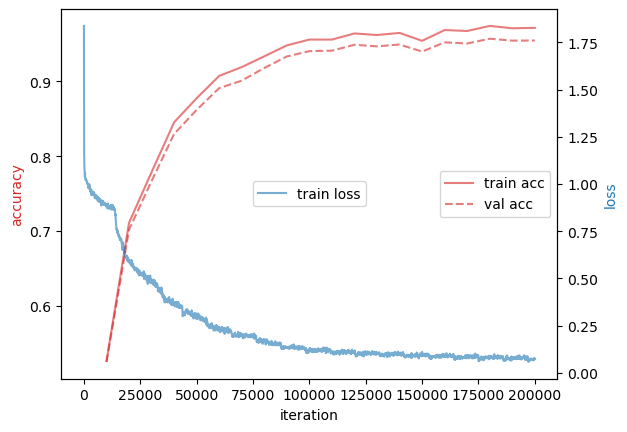

In [18]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots()

color = '#d62728'
ax1.plot(np.arange(len(stats['train_accs'])) * checkpoint_every + checkpoint_every,
         stats['train_accs'], color=color, alpha=0.6, label='train acc')
ax1.plot(np.arange(len(stats['val_accs'])) * checkpoint_every + checkpoint_every,
         stats['val_accs'], linestyle='--', alpha=0.6, color=color, label='val acc')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy', color=color)
ax1.legend(loc='center right')

color = '#1f77b4'
ax2 = ax1.twinx()
ax2.plot(np.arange(len(stats['train_losses'])) * record_loss_every,
         stats['train_losses'], color=color, alpha=0.6, label='train loss')
ax2.set_ylabel('loss', color=color)
ax2.legend(loc='center')

plt.show()

fig.savefig('data/stats/imgs/curves.png', dpi=1200)

In [21]:
print(stats['best_val_acc'])

0.95689074677814
